2025-08-25 02:08:05,086 - INFO - Loading data from C:\Users\DAIICT I\Desktop\Msc DS Sujal 202418017\Interval_Forecast_Normal\df_without_exo.xlsx...
2025-08-25 02:08:05,128 - INFO - Engineering lagged features...
2025-08-25 02:08:05,132 - INFO - Splitting test data at date: 2024-04-01
2025-08-25 02:08:05,133 - INFO - Train size: 750, Validation size: 84, Test size: 89
2025-08-25 02:08:05,139 - INFO - Starting hyperparameter search over 4032 combinations...
2025-08-25 02:08:05,677 - INFO - ✓ Valid model found: PICP=95.18%, MPIW=13.7603 with params {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 2, 'kernel_size': 2, 'learning_rate': 0.005, 'epochs': 100, 'n_gaussians': 2}
2025-08-25 02:08:06,205 - INFO - ✓ Valid model found: PICP=96.39%, MPIW=12.4682 with params {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 2, 'kernel_size': 2, 'learning_rate': 0.005, 'epochs': 100, 'n_gaussians': 3}
2025-08-25 02:08:06,737 - INFO - ✗ Model rejected: PICP=89.16% with params {'seq_len': 1, 'hidden_dim': 32


Best Hyperparameters: {'seq_len': 30, 'hidden_dim': 64, 'num_layers': 2, 'kernel_size': 2, 'learning_rate': 0.005, 'epochs': 100, 'n_gaussians': 5}
Prediction Interval Coverage (PICP): 96.61%
Mean Prediction Interval Width (MPIW): 10.0551
Continuous Ranked Probability Score (CRPS): 1.2459



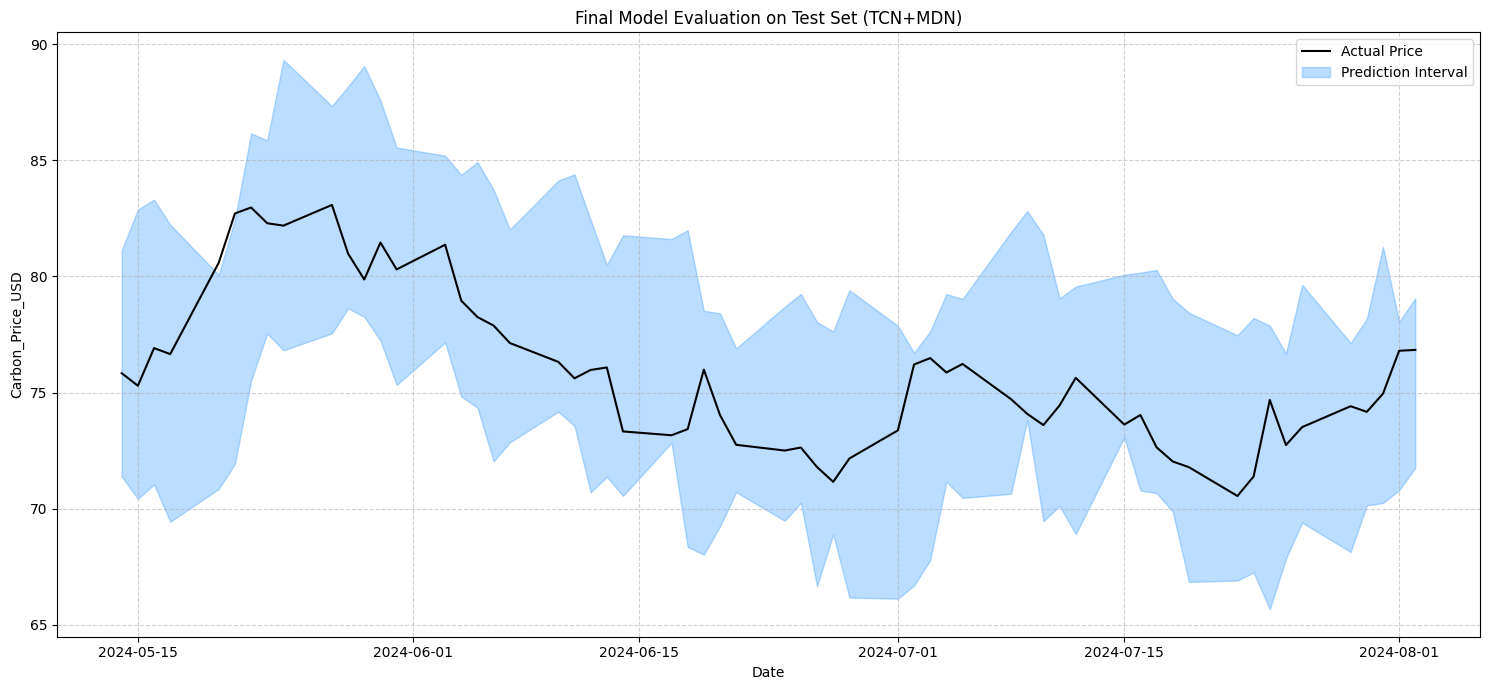

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import itertools
import logging

# torch.manual_seed(42)
# np.random.seed(42)

# --- 1. Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    "file_path": r"C:\Users\DAIICT I\Desktop\Msc DS Sujal 202418017\Interval_Forecast_Normal\df_without_exo.xlsx",
    "target_col": "Carbon_Price_USD",
    "original_features": ['Open', 'High', 'Low', 'Carbon_Price_USD', 'Vol.', 'Change %'],
    
    # --- Splitting Logic ---
    "test_split_date": '2024-04-01',
    "val_ratio_of_train_data": 0.1,
    
    "target_coverage": 95.0,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    
    "param_grid": {
        'seq_len': [1, 5, 10, 15, 20, 25, 30],
        'hidden_dim': [32, 48, 64, 128],      # Num filters/channels for TCN
        'num_layers': [2, 3, 4],          # Num of TCN blocks
        'kernel_size': [2, 3, 4, 5],          # Kernel size for TCN
        'learning_rate': [0.005, 0.001],
        'epochs': [100],
        'n_gaussians': [2, 3, 4, 5, 6, 7]      # Number of mixtures for MDN
    }
}

# --- 2. Self-Contained TCN and MDN Model Definition ---

class CausalConv1d(nn.Module):
    """A 1D causal convolution layer."""
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        super().__init__()
        # Calculate padding to ensure the output has the same length as the input
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation, **kwargs)

    def forward(self, x):
        x = self.conv(x)
        # Remove the padded elements from the end
        return x[:, :, :-self.padding]

class TemporalBlock(nn.Module):
    """A single block of a Temporal Convolutional Network."""
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, dropout=0.2):
        super().__init__()
        self.conv1 = CausalConv1d(n_inputs, n_outputs, kernel_size, stride=stride, dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = CausalConv1d(n_outputs, n_outputs, kernel_size, stride=stride, dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1,
                                 self.conv2, self.relu2, self.dropout2)
        
        # 1x1 convolution for the residual connection if input/output channels differ
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        res = x if self.downsample is None else self.downsample(x)
        out = self.net(x)
        return self.relu(out + res)

class TCN_MDN(nn.Module):
    """TCN model that outputs parameters for a Gaussian Mixture Model."""
    def __init__(self, input_dim, hidden_dim, num_layers, kernel_size, n_gaussians=5, dropout=0.2):
        super().__init__()
        self.n_gaussians = n_gaussians
        layers = []
        num_levels = num_layers
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_dim if i == 0 else hidden_dim
            out_channels = hidden_dim
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size, dropout=dropout)]
        
        self.tcn = nn.Sequential(*layers)
        self.mdn_layer = nn.Linear(hidden_dim, 3 * n_gaussians)

    def forward(self, x):
        x_permuted = x.permute(0, 2, 1)
        tcn_out = self.tcn(x_permuted)
        last_time_step = tcn_out[:, :, -1]
        mdn_params = self.mdn_layer(last_time_step)
        
        pi_logits = mdn_params[:, :self.n_gaussians]
        mu = mdn_params[:, self.n_gaussians:2*self.n_gaussians]
        sigma_logits = mdn_params[:, 2*self.n_gaussians:]
        
        pi = torch.softmax(pi_logits, dim=1)
        
        # stabilize sigma
        sigma = F.softplus(sigma_logits) + 1e-3
        sigma = torch.clamp(sigma, min=1e-3, max=5.0)
        
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y_true):
    mix = D.Categorical(pi)
    comp = D.Normal(mu, sigma)
    gmm = D.MixtureSameFamily(mix, comp)
    loss = -gmm.log_prob(y_true.squeeze())

    if torch.isnan(loss).any() or torch.isinf(loss).any():
        return torch.tensor(0.0, requires_grad=True, device=loss.device)

    return loss.mean()

# --- 3. Pipeline Functions ---

def load_and_clean_data(file_path):
    logging.info(f"Loading data from {file_path}...")
    df = pd.read_excel(file_path) 
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.sort_values('Date', inplace=True)
    if pd.api.types.is_object_dtype(df['Vol.']):
        def convert_volume(vol):
            try:
                if isinstance(vol, str):
                    vol = vol.replace('K', '*1e3').replace('M', '*1e6')
                    return eval(vol)
                return np.nan
            except: return np.nan
        df['Vol.'] = df['Vol.'].apply(convert_volume)
    df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
    df['Change %'] = pd.to_numeric(df['Change %'], errors='coerce')
    df.set_index('Date', inplace=True)
    return df

def engineer_features(df, original_features, target_col):
    logging.info("Engineering lagged features...")
    for feature in original_features:
        df[f'{feature}_lag1'] = df[feature].shift(1)
    feature_cols = [f'{col}_lag1' for col in original_features]
    df.dropna(inplace=True)
    if df.empty:
        raise ValueError("DataFrame is empty after feature engineering.")
    X = df[feature_cols]
    y = df[[target_col]]
    return X, y

def split_and_scale_data(X, y, test_split_date, val_ratio):
    logging.info(f"Splitting test data at date: {test_split_date}")
    test_split_date = pd.to_datetime(test_split_date)
    train_val_mask = X.index < test_split_date
    X_train_val, X_test = X[train_val_mask], X[~train_val_mask]
    y_train_val, y_test = y[train_val_mask], y[~train_val_mask]
    val_split_index = int(len(X_train_val) * (1 - val_ratio))
    X_train, X_val = X_train_val[:val_split_index], X_train_val[val_split_index:]
    y_train, y_val = y_train_val[:val_split_index], y_train_val[val_split_index:]
    logging.info(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
         raise ValueError("One of the data splits is empty.")
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)
    X_val_scaled = scaler_X.transform(X_val)
    y_val_scaled = scaler_y.transform(y_val)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)
    return (X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, 
            X_test_scaled, y_test_scaled, scaler_y)

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

def train_mdn_model(X_train, y_train, params):
    """Trains a single TCN MDN model."""
    model = TCN_MDN(
        input_dim=X_train.shape[2], 
        hidden_dim=params['hidden_dim'], 
        num_layers=params['num_layers'],
        kernel_size=params['kernel_size'],
        n_gaussians=params['n_gaussians']
    ).to(CONFIG['device'])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(CONFIG['device'])
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(CONFIG['device'])

    for _ in range(params['epochs']):
        model.train()
        optimizer.zero_grad()
        pi, mu, sigma = model(X_train_t)
        loss = mdn_loss(pi, mu, sigma, y_train_t)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.01)
        optimizer.step()
    return model

def calculate_all_metrics(pi, mu, sigma, y_true_scaled, scaler_y, lower_q=0.025, upper_q=0.975, n_samples=1000):
    """Calculates PICP, MPIW, and CRPS by sampling from the GMM."""
    with torch.no_grad():
        pi, mu, sigma = pi.cpu(), mu.cpu(), sigma.cpu()
        y_true_scaled = y_true_scaled.cpu()

        # Create the GMM distribution
        mix = D.Categorical(pi)
        comp = D.Normal(mu, sigma)
        gmm = D.MixtureSameFamily(mix, comp)

        # Generate samples for interval and CRPS
        # Shape of samples will be (n_samples, batch_size)
        samples_scaled_1 = gmm.sample((n_samples,))
        samples_scaled_2 = gmm.sample((n_samples,))

        # Inverse transform everything to the original scale
        y_true_inv = scaler_y.inverse_transform(y_true_scaled).flatten()
        
        # Transpose samples to (batch_size, n_samples) before inverse transform
        samples_inv_1 = scaler_y.inverse_transform(samples_scaled_1.T)
        samples_inv_2 = scaler_y.inverse_transform(samples_scaled_2.T)

        # --- PICP & MPIW ---
        lower = np.quantile(samples_inv_1, lower_q, axis=1)
        upper = np.quantile(samples_inv_1, upper_q, axis=1)
        picp = np.mean((y_true_inv >= lower) & (y_true_inv <= upper)) * 100
        mpiw = np.mean(upper - lower)

        # --- CRPS ---
        # Reshape y_true_inv for broadcasting: (batch_size,) -> (batch_size, 1)
        term1 = np.mean(np.abs(samples_inv_1 - y_true_inv.reshape(-1, 1)), axis=1)
        term2 = 0.5 * np.mean(np.abs(samples_inv_1 - samples_inv_2), axis=1)
        crps = np.mean(term1 - term2)

        return picp, mpiw, crps, lower, upper

def find_best_hyperparameters(train_data, val_data, param_grid, scaler_y):
    X_train_scaled, y_train_scaled = train_data
    X_val_scaled, y_val_scaled = val_data
    valid_models = []
    param_combinations = list(itertools.product(*param_grid.values()))
    logging.info(f"Starting hyperparameter search over {len(param_combinations)} combinations...")

    for values in param_combinations:
        params = dict(zip(param_grid.keys(), values))
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, params['seq_len'])
        X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, params['seq_len'])
        if len(X_val_seq) == 0: continue
        model = train_mdn_model(X_train_seq, y_train_seq, params)
        X_val_t = torch.tensor(X_val_seq, dtype=torch.float32).to(CONFIG['device'])
        y_val_t = torch.tensor(y_val_seq, dtype=torch.float32)
        with torch.no_grad():
            pi, mu, sigma = model(X_val_t)
        
        picp, mpiw, _, _, _ = calculate_all_metrics(pi, mu, sigma, y_val_t, scaler_y)

        if picp >= CONFIG['target_coverage']:
            logging.info(f"✓ Valid model found: PICP={picp:.2f}%, MPIW={mpiw:.4f} with params {params}")
            valid_models.append({'mpiw': mpiw, 'params': params})
        else:
            logging.info(f"✗ Model rejected: PICP={picp:.2f}% with params {params}")

    if not valid_models:
        raise ValueError("No valid hyperparameters found that meet the PICP threshold.")
    best_model_info = min(valid_models, key=lambda x: x['mpiw'])
    return best_model_info['params']

def evaluate_on_test_set(best_params, train_val_data, test_data, scaler_y):
    X_train_val_scaled, y_train_val_scaled = train_val_data
    X_test_scaled, y_test_scaled = test_data
    logging.info("Training final model on combined train+validation data...")
    X_train_val_seq, y_train_val_seq = create_sequences(X_train_val_scaled, y_train_val_scaled, best_params['seq_len'])
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, best_params['seq_len'])
    model = train_mdn_model(X_train_val_seq, y_train_val_seq, best_params)
    logging.info("Evaluating final model on the test set...")
    X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(CONFIG['device'])
    y_test_t = torch.tensor(y_test_seq, dtype=torch.float32)
    with torch.no_grad():
        pi, mu, sigma = model(X_test_t)
    
    picp, mpiw, crps, pred_lower, pred_upper = calculate_all_metrics(pi, mu, sigma, y_test_t, scaler_y)
    y_test_true = scaler_y.inverse_transform(y_test_seq).flatten()

    results = {"picp": picp, "mpiw": mpiw, "crps": crps}
    plot_data = {"pred_lower": pred_lower, "pred_upper": pred_upper, "y_true": y_test_true}
    return results, plot_data

def plot_results(plot_data, test_dates):
    logging.info("Generating final plot...")
    y_true = plot_data['y_true']
    dates_for_plot = test_dates[-len(y_true):]
    plt.figure(figsize=(15, 7))
    plt.plot(dates_for_plot, y_true, label='Actual Price', color='black', linewidth=1.5)
    plt.fill_between(dates_for_plot, plot_data['pred_lower'], plot_data['pred_upper'], 
                       color='dodgerblue', alpha=0.3, label=f'Prediction Interval')
    plt.title('Final Model Evaluation on Test Set (TCN+MDN)')
    plt.xlabel('Date')
    plt.ylabel(CONFIG['target_col'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- 4. Main Execution ---
def main():
    df = load_and_clean_data(CONFIG['file_path'])
    X, y = engineer_features(df, CONFIG['original_features'], CONFIG['target_col'])
    (X_train_s, y_train_s, X_val_s, y_val_s, 
     X_test_s, y_test_s, scaler_y) = split_and_scale_data(
         X, y, 
         test_split_date=CONFIG['test_split_date'], 
         val_ratio=CONFIG['val_ratio_of_train_data']
    )
    best_params = find_best_hyperparameters(
        train_data=(X_train_s, y_train_s),
        val_data=(X_val_s, y_val_s),
        param_grid=CONFIG['param_grid'],
        scaler_y=scaler_y
    )
    X_train_val_s = np.concatenate((X_train_s, X_val_s), axis=0)
    y_train_val_s = np.concatenate((y_train_s, y_val_s), axis=0)
    final_results, plot_data = evaluate_on_test_set(
        best_params=best_params,
        train_val_data=(X_train_val_s, y_train_val_s),
        test_data=(X_test_s, y_test_s),
        scaler_y=scaler_y
    )
    print("\n" + "="*40)
    logging.info("Final Model Performance on Test Set")
    print("="*40)
    print(f"Best Hyperparameters: {best_params}")
    print(f"Prediction Interval Coverage (PICP): {final_results['picp']:.2f}%")
    print(f"Mean Prediction Interval Width (MPIW): {final_results['mpiw']:.4f}")
    print(f"Continuous Ranked Probability Score (CRPS): {final_results['crps']:.4f}")
    print("="*40 + "\n")
    test_dates_index = X[X.index >= pd.to_datetime(CONFIG['test_split_date'])].index
    plot_results(plot_data, test_dates=test_dates_index)

if __name__ == "__main__":
    main()


2025-08-25 01:18:41,254 - INFO - Loading data from C:\Users\DAIICT I\Desktop\Msc DS Sujal 202418017\Interval_Forecast_Normal\df_without_exo.xlsx...
2025-08-25 01:18:41,284 - INFO - Engineering lagged features...
2025-08-25 01:18:41,285 - INFO - Splitting test data at date: 2024-04-01
2025-08-25 01:18:41,287 - INFO - Train size: 750, Validation size: 84, Test size: 89
2025-08-25 01:18:41,289 - INFO - Starting hyperparameter search over 4032 combinations...
2025-08-25 01:18:41,565 - INFO - ✗ Model rejected: PICP=93.98% with params {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 2, 'kernel_size': 2, 'learning_rate': 0.005, 'epochs': 100, 'n_gaussians': 2}
2025-08-25 01:18:41,837 - INFO - ✗ Model rejected: PICP=92.77% with params {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 2, 'kernel_size': 2, 'learning_rate': 0.005, 'epochs': 100, 'n_gaussians': 3}
2025-08-25 01:18:42,110 - INFO - ✗ Model rejected: PICP=93.98% with params {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 2, 'kernel_size': 


Best Hyperparameters: {'seq_len': 20, 'hidden_dim': 32, 'num_layers': 2, 'kernel_size': 5, 'learning_rate': 0.005, 'epochs': 100, 'n_gaussians': 4}
Prediction Interval Coverage (PICP): 100.00%
Mean Prediction Interval Width (MPIW): 11.2403
Continuous Ranked Probability Score (CRPS): 1.2755



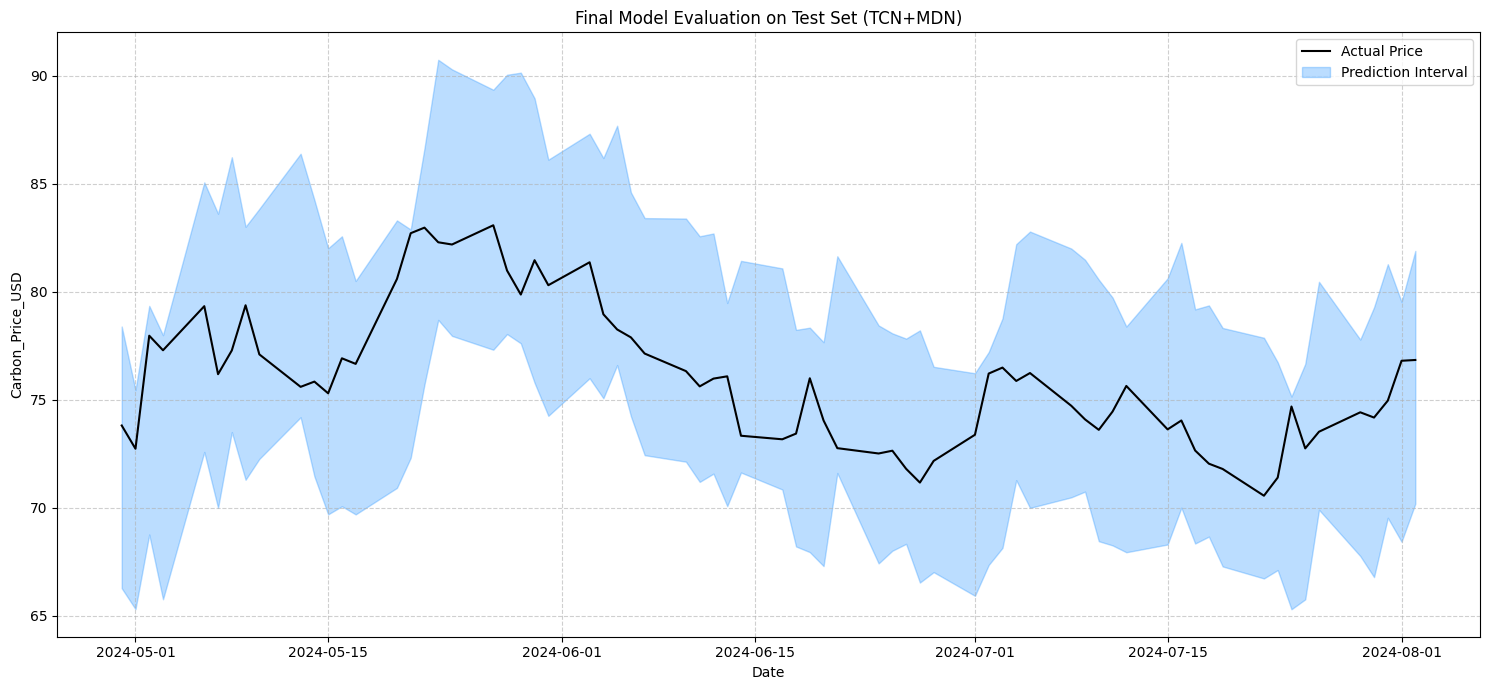

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import itertools
import logging

torch.manual_seed(42)
np.random.seed(42)

# --- 1. Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    "file_path": r"C:\Users\DAIICT I\Desktop\Msc DS Sujal 202418017\Interval_Forecast_Normal\df_without_exo.xlsx",
    "target_col": "Carbon_Price_USD",
    "original_features": ['Carbon_Price_USD'],
    
    # --- Splitting Logic ---
    "test_split_date": '2024-04-01',
    "val_ratio_of_train_data": 0.1,
    
    "target_coverage": 95.0,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    
    "param_grid": {
        'seq_len': [1, 5, 10, 15, 20, 25, 30],
        'hidden_dim': [32, 48, 64, 128],      # Num filters/channels for TCN
        'num_layers': [2, 3, 4],          # Num of TCN blocks
        'kernel_size': [2, 3, 4, 5],          # Kernel size for TCN
        'learning_rate': [0.005, 0.001],
        'epochs': [100],
        'n_gaussians': [2, 3, 4, 5, 6, 7]      # Number of mixtures for MDN
    }
}

# --- 2. Self-Contained TCN and MDN Model Definition ---

class CausalConv1d(nn.Module):
    """A 1D causal convolution layer."""
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        super().__init__()
        # Calculate padding to ensure the output has the same length as the input
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation, **kwargs)

    def forward(self, x):
        x = self.conv(x)
        # Remove the padded elements from the end
        return x[:, :, :-self.padding]

class TemporalBlock(nn.Module):
    """A single block of a Temporal Convolutional Network."""
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, dropout=0.2):
        super().__init__()
        self.conv1 = CausalConv1d(n_inputs, n_outputs, kernel_size, stride=stride, dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = CausalConv1d(n_outputs, n_outputs, kernel_size, stride=stride, dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1,
                                 self.conv2, self.relu2, self.dropout2)
        
        # 1x1 convolution for the residual connection if input/output channels differ
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        res = x if self.downsample is None else self.downsample(x)
        out = self.net(x)
        return self.relu(out + res)

class TCN_MDN(nn.Module):
    """TCN model that outputs parameters for a Gaussian Mixture Model."""
    def __init__(self, input_dim, hidden_dim, num_layers, kernel_size, n_gaussians=5, dropout=0.2):
        super().__init__()
        self.n_gaussians = n_gaussians
        layers = []
        num_levels = num_layers
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_dim if i == 0 else hidden_dim
            out_channels = hidden_dim
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size, dropout=dropout)]
        
        self.tcn = nn.Sequential(*layers)
        self.mdn_layer = nn.Linear(hidden_dim, 3 * n_gaussians)

    def forward(self, x):
        x_permuted = x.permute(0, 2, 1)
        tcn_out = self.tcn(x_permuted)
        last_time_step = tcn_out[:, :, -1]
        mdn_params = self.mdn_layer(last_time_step)
        
        pi_logits = mdn_params[:, :self.n_gaussians]
        mu = mdn_params[:, self.n_gaussians:2*self.n_gaussians]
        sigma_logits = mdn_params[:, 2*self.n_gaussians:]
        
        pi = torch.softmax(pi_logits, dim=1)
        
        # stabilize sigma
        sigma = F.softplus(sigma_logits) + 1e-3
        sigma = torch.clamp(sigma, min=1e-3, max=5.0)
        
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y_true):
    mix = D.Categorical(pi)
    comp = D.Normal(mu, sigma)
    gmm = D.MixtureSameFamily(mix, comp)
    loss = -gmm.log_prob(y_true.squeeze())

    if torch.isnan(loss).any() or torch.isinf(loss).any():
        return torch.tensor(0.0, requires_grad=True, device=loss.device)

    return loss.mean()

# --- 3. Pipeline Functions ---

def load_and_clean_data(file_path):
    logging.info(f"Loading data from {file_path}...")
    df = pd.read_excel(file_path) 
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.sort_values('Date', inplace=True)
    if pd.api.types.is_object_dtype(df['Vol.']):
        def convert_volume(vol):
            try:
                if isinstance(vol, str):
                    vol = vol.replace('K', '*1e3').replace('M', '*1e6')
                    return eval(vol)
                return np.nan
            except: return np.nan
        df['Vol.'] = df['Vol.'].apply(convert_volume)
    df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
    df['Change %'] = pd.to_numeric(df['Change %'], errors='coerce')
    df.set_index('Date', inplace=True)
    return df

def engineer_features(df, original_features, target_col):
    logging.info("Engineering lagged features...")
    for feature in original_features:
        df[f'{feature}_lag1'] = df[feature].shift(1)
    feature_cols = [f'{col}_lag1' for col in original_features]
    df.dropna(inplace=True)
    if df.empty:
        raise ValueError("DataFrame is empty after feature engineering.")
    X = df[feature_cols]
    y = df[[target_col]]
    return X, y

def split_and_scale_data(X, y, test_split_date, val_ratio):
    logging.info(f"Splitting test data at date: {test_split_date}")
    test_split_date = pd.to_datetime(test_split_date)
    train_val_mask = X.index < test_split_date
    X_train_val, X_test = X[train_val_mask], X[~train_val_mask]
    y_train_val, y_test = y[train_val_mask], y[~train_val_mask]
    val_split_index = int(len(X_train_val) * (1 - val_ratio))
    X_train, X_val = X_train_val[:val_split_index], X_train_val[val_split_index:]
    y_train, y_val = y_train_val[:val_split_index], y_train_val[val_split_index:]
    logging.info(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
         raise ValueError("One of the data splits is empty.")
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)
    X_val_scaled = scaler_X.transform(X_val)
    y_val_scaled = scaler_y.transform(y_val)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)
    return (X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, 
            X_test_scaled, y_test_scaled, scaler_y)

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

def train_mdn_model(X_train, y_train, params):
    """Trains a single TCN MDN model."""
    model = TCN_MDN(
        input_dim=X_train.shape[2], 
        hidden_dim=params['hidden_dim'], 
        num_layers=params['num_layers'],
        kernel_size=params['kernel_size'],
        n_gaussians=params['n_gaussians']
    ).to(CONFIG['device'])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(CONFIG['device'])
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(CONFIG['device'])

    for _ in range(params['epochs']):
        model.train()
        optimizer.zero_grad()
        pi, mu, sigma = model(X_train_t)
        loss = mdn_loss(pi, mu, sigma, y_train_t)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.01)
        optimizer.step()
    return model

def calculate_all_metrics(pi, mu, sigma, y_true_scaled, scaler_y, lower_q=0.025, upper_q=0.975, n_samples=1000):
    """Calculates PICP, MPIW, and CRPS by sampling from the GMM."""
    with torch.no_grad():
        pi, mu, sigma = pi.cpu(), mu.cpu(), sigma.cpu()
        y_true_scaled = y_true_scaled.cpu()

        # Create the GMM distribution
        mix = D.Categorical(pi)
        comp = D.Normal(mu, sigma)
        gmm = D.MixtureSameFamily(mix, comp)

        # Generate samples for interval and CRPS
        # Shape of samples will be (n_samples, batch_size)
        samples_scaled_1 = gmm.sample((n_samples,))
        samples_scaled_2 = gmm.sample((n_samples,))

        # Inverse transform everything to the original scale
        y_true_inv = scaler_y.inverse_transform(y_true_scaled).flatten()
        
        # Transpose samples to (batch_size, n_samples) before inverse transform
        samples_inv_1 = scaler_y.inverse_transform(samples_scaled_1.T)
        samples_inv_2 = scaler_y.inverse_transform(samples_scaled_2.T)

        # --- PICP & MPIW ---
        lower = np.quantile(samples_inv_1, lower_q, axis=1)
        upper = np.quantile(samples_inv_1, upper_q, axis=1)
        picp = np.mean((y_true_inv >= lower) & (y_true_inv <= upper)) * 100
        mpiw = np.mean(upper - lower)

        # --- CRPS ---
        # Reshape y_true_inv for broadcasting: (batch_size,) -> (batch_size, 1)
        term1 = np.mean(np.abs(samples_inv_1 - y_true_inv.reshape(-1, 1)), axis=1)
        term2 = 0.5 * np.mean(np.abs(samples_inv_1 - samples_inv_2), axis=1)
        crps = np.mean(term1 - term2)

        return picp, mpiw, crps, lower, upper

def find_best_hyperparameters(train_data, val_data, param_grid, scaler_y):
    X_train_scaled, y_train_scaled = train_data
    X_val_scaled, y_val_scaled = val_data
    valid_models = []
    param_combinations = list(itertools.product(*param_grid.values()))
    logging.info(f"Starting hyperparameter search over {len(param_combinations)} combinations...")

    for values in param_combinations:
        params = dict(zip(param_grid.keys(), values))
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, params['seq_len'])
        X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, params['seq_len'])
        if len(X_val_seq) == 0: continue
        model = train_mdn_model(X_train_seq, y_train_seq, params)
        X_val_t = torch.tensor(X_val_seq, dtype=torch.float32).to(CONFIG['device'])
        y_val_t = torch.tensor(y_val_seq, dtype=torch.float32)
        with torch.no_grad():
            pi, mu, sigma = model(X_val_t)
        
        picp, mpiw, _, _, _ = calculate_all_metrics(pi, mu, sigma, y_val_t, scaler_y)

        if picp >= CONFIG['target_coverage']:
            logging.info(f"✓ Valid model found: PICP={picp:.2f}%, MPIW={mpiw:.4f} with params {params}")
            valid_models.append({'mpiw': mpiw, 'params': params})
        else:
            logging.info(f"✗ Model rejected: PICP={picp:.2f}% with params {params}")

    if not valid_models:
        raise ValueError("No valid hyperparameters found that meet the PICP threshold.")
    best_model_info = min(valid_models, key=lambda x: x['mpiw'])
    return best_model_info['params']

def evaluate_on_test_set(best_params, train_val_data, test_data, scaler_y):
    X_train_val_scaled, y_train_val_scaled = train_val_data
    X_test_scaled, y_test_scaled = test_data
    logging.info("Training final model on combined train+validation data...")
    X_train_val_seq, y_train_val_seq = create_sequences(X_train_val_scaled, y_train_val_scaled, best_params['seq_len'])
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, best_params['seq_len'])
    model = train_mdn_model(X_train_val_seq, y_train_val_seq, best_params)
    logging.info("Evaluating final model on the test set...")
    X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(CONFIG['device'])
    y_test_t = torch.tensor(y_test_seq, dtype=torch.float32)
    with torch.no_grad():
        pi, mu, sigma = model(X_test_t)
    
    picp, mpiw, crps, pred_lower, pred_upper = calculate_all_metrics(pi, mu, sigma, y_test_t, scaler_y)
    y_test_true = scaler_y.inverse_transform(y_test_seq).flatten()

    results = {"picp": picp, "mpiw": mpiw, "crps": crps}
    plot_data = {"pred_lower": pred_lower, "pred_upper": pred_upper, "y_true": y_test_true}
    return results, plot_data

def plot_results(plot_data, test_dates):
    logging.info("Generating final plot...")
    y_true = plot_data['y_true']
    dates_for_plot = test_dates[-len(y_true):]
    plt.figure(figsize=(15, 7))
    plt.plot(dates_for_plot, y_true, label='Actual Price', color='black', linewidth=1.5)
    plt.fill_between(dates_for_plot, plot_data['pred_lower'], plot_data['pred_upper'], 
                       color='dodgerblue', alpha=0.3, label=f'Prediction Interval')
    plt.title('Final Model Evaluation on Test Set (TCN+MDN)')
    plt.xlabel('Date')
    plt.ylabel(CONFIG['target_col'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- 4. Main Execution ---
def main():
    df = load_and_clean_data(CONFIG['file_path'])
    X, y = engineer_features(df, CONFIG['original_features'], CONFIG['target_col'])
    (X_train_s, y_train_s, X_val_s, y_val_s, 
     X_test_s, y_test_s, scaler_y) = split_and_scale_data(
         X, y, 
         test_split_date=CONFIG['test_split_date'], 
         val_ratio=CONFIG['val_ratio_of_train_data']
    )
    best_params = find_best_hyperparameters(
        train_data=(X_train_s, y_train_s),
        val_data=(X_val_s, y_val_s),
        param_grid=CONFIG['param_grid'],
        scaler_y=scaler_y
    )
    X_train_val_s = np.concatenate((X_train_s, X_val_s), axis=0)
    y_train_val_s = np.concatenate((y_train_s, y_val_s), axis=0)
    final_results, plot_data = evaluate_on_test_set(
        best_params=best_params,
        train_val_data=(X_train_val_s, y_train_val_s),
        test_data=(X_test_s, y_test_s),
        scaler_y=scaler_y
    )
    print("\n" + "="*40)
    logging.info("Final Model Performance on Test Set")
    print("="*40)
    print(f"Best Hyperparameters: {best_params}")
    print(f"Prediction Interval Coverage (PICP): {final_results['picp']:.2f}%")
    print(f"Mean Prediction Interval Width (MPIW): {final_results['mpiw']:.4f}")
    print(f"Continuous Ranked Probability Score (CRPS): {final_results['crps']:.4f}")
    print("="*40 + "\n")
    test_dates_index = X[X.index >= pd.to_datetime(CONFIG['test_split_date'])].index
    plot_results(plot_data, test_dates=test_dates_index)

if __name__ == "__main__":
    main()
